# Initial Requirements
Demonstrate gradients at the components of the equations in a neural network

From Andrej Karpathy's ["The spelled-out intro to neural networks and backpropagation: building micrograd"](https://www.youtube.com/watch?v=VMj-3S1tku0&t)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
from graphviz import Digraph

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

In [5]:
# Derivative: rate of change of the slope of the tangent at a point in the function
# amount of change to measure
h = 0.000000001

# point under consideration
x = 3.0

# slope at the point
m = lambda x, h: (f(x + h) - f(x))/h

In [6]:
m(x, h)

14.000001158365194

In [7]:
# plot of the line tangent at point x
def line_plot(x, m, xl):
    b = f(x) - m*x
    ys = m * xl + b
    return ys

In [8]:
mx = m(x, h)
xl = np.arange(-5, 5, 0.1)
yl = line_plot(x, mx, xl)

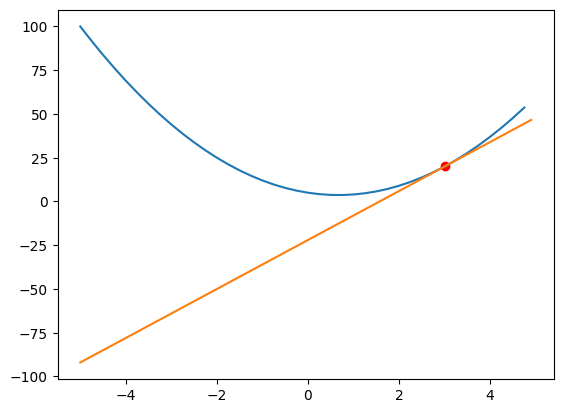

In [9]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.plot(xl, yl)
plt.scatter(x, f(x), c="red")
plt.show()

In [10]:
# example 2
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d = a*b + c

In [11]:
# evalute the derrivative of d with respect to a, b, and c

In [12]:
# for each variable 
d1 = a*b + c
c += h
d2 = a*b + c

In [13]:
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


## Value Object
in order to encompass larger data types

In [14]:
class Value:
    # _children and _op at init requires values, used for history
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        # gradient at each leaf/Value
        self.grad = 0 # initially set to 0 with the assumption that the leaf/Value
                      # does not effect the overall outcome (Loss Function)
            
        # to capture the previous values and operations
        self._prev = set(_children)
        self._op = _op  # operation performed at the node
        self.label = label # name of the node
        
    def __repr__(self):
        # necessary to print out something readable -- otherwise shows
        # the function and location in memory
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # other must be a second Value object
        # pass children values to capture history
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*') 
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        return out

In [15]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

In [16]:
e = a*b; e.label='e'
d = e + c; d.label='d'
d

Value(data=4.0)

In [17]:
f = Value(-2.0, label='f')

In [18]:
L = d *f; L.label='L'
L

Value(data=-8.0)

In [19]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [20]:
d._op

'+'

## Visualizing the expressions
forward pass

In [21]:
from graphviz import Digraph

In [22]:
def trace(root):
    # builds a set of all nodes and edges in a graph -- from a Value Object
    
    nodes, edges = set(), set()
    
    def build(v):
    # build reaches up out of scope to access nodes and edges... 
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                # recursive call to elaborate all of the child nodes 
                build(child)
    build(root)
    return nodes, edges


In [23]:
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        # for any value in the graph, create a rectangular ('record') node for it
        # each node displays label, data, and gradient at that leaf
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

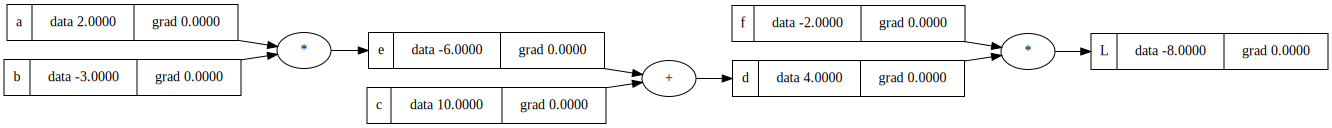

In [24]:
draw_dot(L)

### calculate the derrivative of each node with respect to L
variable within the Value class to capture the derrivative at each leaf; **grad**

how much a change at each leaf will impact the overall value of L

In [25]:
# to maintain local scope, use a helper function
def lol_a():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d *f; L.label='L'
    L1 = L.data
    
    # adjust a by adding h; derrivative of L with respect to a
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d *f; L.label='L'
    L2 = L.data
    
    print((L2 - L1)/h)
    

In [26]:
lol_a()

6.000000000021544


### Deriving the derivative at d:
L = d * f

dL/dd = ? <-- f

(f(x+h) - f(x))/h

((d+h)* f - d * f)/h

(d*f + h*f - d * f)/h

(h * f) /h

f

In [27]:
f.grad = 4.0 # data of the other value in the expression
d.grad = -2.0

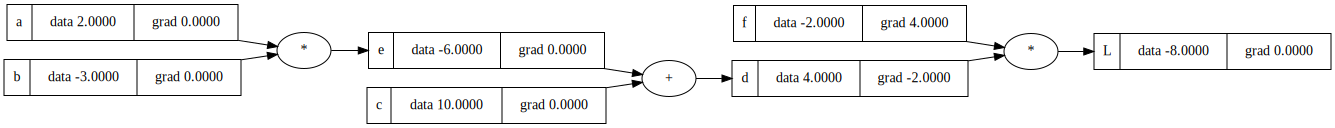

In [28]:
draw_dot(L)

In [29]:
def lol_f():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d *f; L.label='L'
    L1 = L.data
    
    # adjust f by adding h; derrivative of L with respect to f
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0 + h, label='f')
    L = d *f; L.label='L'
    L2 = L.data
    
    print((L2 - L1)/h)

In [30]:
def lol_d():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d *f; L.label='L'
    L1 = L.data
    
    # adjust d by adding h; derrivative of L with respect to d
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    d.data += h
    f = Value(-2.0, label='f')
    L = d *f; L.label='L'
    L2 = L.data
    
    print((L2 - L1)/h)

In [31]:
lol_f(), lol_d()

# demonstrates that the derrivative of L with respect to f is approaching 4
# and of L with respect to d is approaching -2.0

3.9999999999995595
-2.000000000000668


(None, None)

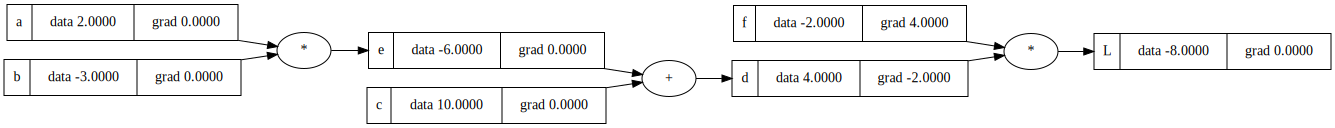

In [32]:
draw_dot(L)

### dL/dc; how is L sensitive to c?

#### first: dd/dc = 1.0 and dd/de = 1.0

d = c + e

(f(x+h) - f(x))/h <-- standard derivative formula

((c+h - e) - (c + e))/h

h/h --> 1.0


### Calculate dL/dc through the [Chain Rule](https://en.wikipedia.org/wiki/Chain_rule#Intuitive_explanation:~:text=Intuitive%20explanation%5Bedit%5D)

WANT:
dL/dc

KNOW:
dL/dd
dd/dc

dL/dc = (dL/dd) * (dd/dc)  <-- by the Chain Rule

      = -2.0 * 1
      
      = -2.0

In [33]:
# set the gradients within the network
c.grad = -2.0
e.grad = -2.0

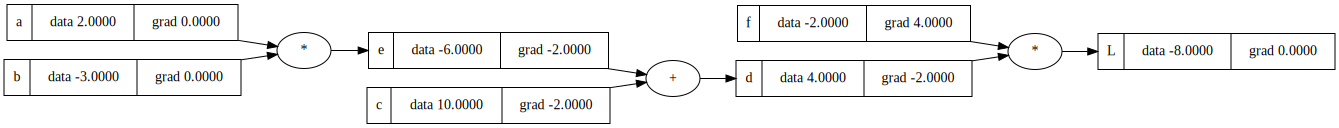

In [34]:
draw_dot(L)

### Confirm the intuition: 

In [35]:
# works for both c and e

def lol_c():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d *f; L.label='L'
    L1 = L.data
    
    # adjust d by adding h; derrivative of L with respect to d
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    c.data += h
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d *f; L.label='L'
    L2 = L.data
    
    print((L2 - L1)/h)

In [36]:
lol_c()

-1.9999999999988916


### Recurse back to find the gradient of the original nodes
WANT: dL/da

dL/de = -2.0

e = a * b

de/da = b

dL/da = (dL/de) * (de/da)


In [37]:
a.grad = -2.0 * -3.0  # (dL/de) * (de/da)
b.grad = -2.0 * 2.0   # (dL/de) * (de/db)

### Confirm the intuiton:


In [38]:
# perform for a and b
def lol_ab():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d *f; L.label='L'
    L1 = L.data
    
    # adjust d by adding h; derrivative of L with respect to d
    a = Value(2.0, label='a')
#    a.data += h
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d *f; L.label='L'
    L2 = L.data
    
    print((L2 - L1)/h)

In [39]:
lol_ab()

-3.9999999999995595


### Demonstrate the gradient adjustment

In [40]:
a.data += 0.01 * a.grad 
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

In [41]:
e = a*b; e.label='e'
d = e + c; d.label='d'

In [42]:
L = d *f; L.label='L'

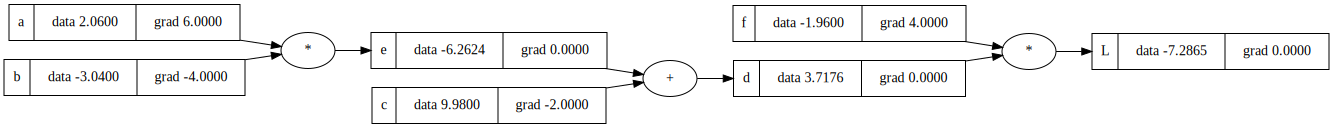

In [43]:
draw_dot(L)

# Backpropagation through a neuron

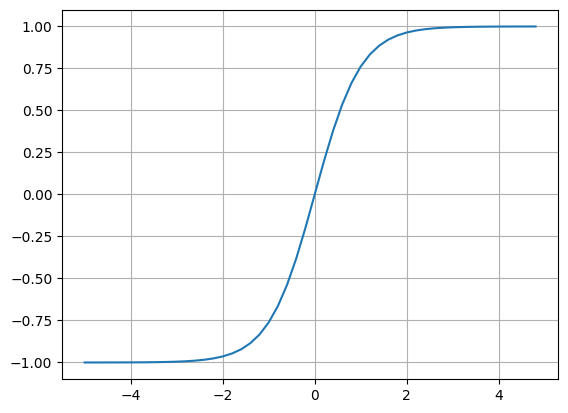

In [44]:
# multiple activatte functions possible; purpose to constrain outputs to a given range

# tanh function: constrains output to between -1 and 1

plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

In [45]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias 
b = Value(6.8813735870195432, label='b')

In [46]:
# 
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'

In [47]:
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

In [48]:
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

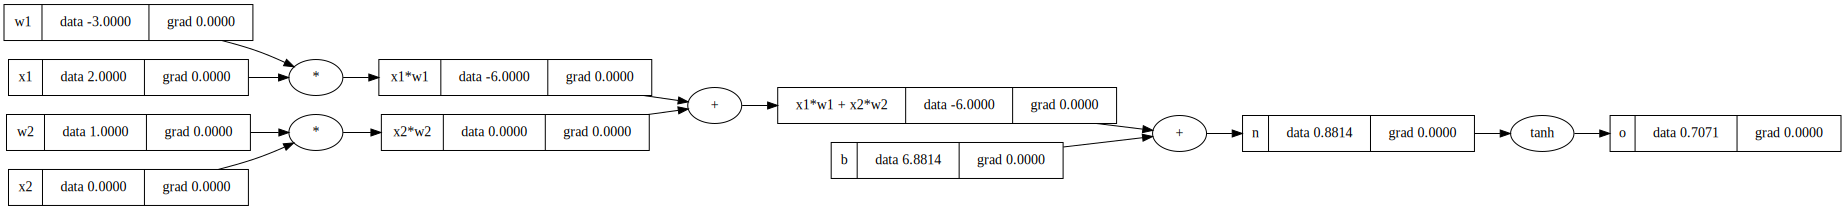

In [49]:
draw_dot(o)

In [50]:
# tanh added to the Value object... 

In [51]:
# primary interest is the derrivatives of the weights

# gradient of itself:
o.grad = 1.0

Working backwards from o:

o = tanh(n)

[derivative at o](https://en.wikipedia.org/wiki/Hyperbolic_functions#:~:text=0-,Derivatives,-%5Bedit%5D):

do/dn = 1 - tanh<sup>2</sup>n   

do/dn = 1 - o<sup>2</sup>

In [52]:
# local derivative of o; the gradient of n, the amount that a change in n will effect o
dodn = 1 - o.data**2
dodn

0.4999999999999999

In [53]:
n.grad = 0.5 # rounded... 

In [54]:
# across an addition the value is distributed evenly; 1.0
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [55]:
# again addition evenly distributes:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [56]:
# these are the values that can be adjusted when tuning the neural network

# moving back across the multiplication requires the other term and the following gradient:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [57]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

# Automating the backpropagation

In [58]:
class Value:
    # _children and _op at init requires values, used for history
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        # gradient at each leaf/Value
        self.grad = 0 # initially set to 0 with the assumption that the leaf/Value
                      # does not effect the overall outcome (Loss Function)
            
        # backward as a attribute of the Value object
        # stores the gradient calculation at a given value (node)
        # by default None, depends on the operation and the children nodes
        self._backward = lambda: None
            
        # to capture the previous values and operations
        self._prev = set(_children)
        self._op = _op  # operation performed at the node
        self.label = label # name of the node
        
    def __repr__(self):
        # necessary to print out something readable -- otherwise shows
        # the function and location in memory
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # other must be a second Value object
        # pass children values to capture history
        out = Value(self.data + other.data, (self, other), '+')
        
        # closure to manage the backpropagation local to the operation
        def _backward():
            # addition propagates the gradient forward 
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        # an addition node has this function as the action for backpropagation
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*') 
        
        def _backward():
            self.grad = out.grad * other.data
            other.grad = out.grad * self.data
            
        out._backward = _backward    
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad = (1 - t**2) *out.grad # local gradient chained to the prior gradient
            
        out._backward = _backward
        return out

In [59]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias 
b = Value(6.8813735870195432, label='b')

In [60]:
# 
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'

In [61]:
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

In [62]:
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

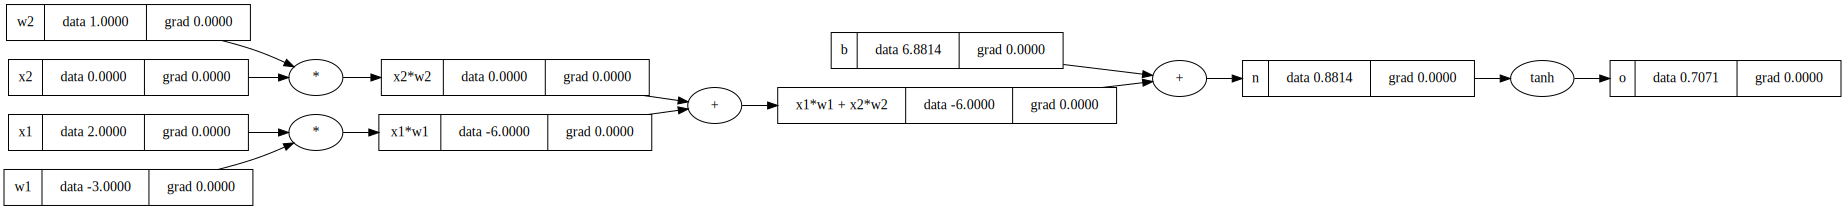

In [63]:
draw_dot(o)

In [63]:
# initialize o.grad

o.grad = 1.0

# gradient at n
o._backward()

In [64]:
# gradient for x1w1x2w2 and b
n._backward()

In [65]:
# unconnected leaf node will have a None gradient
b._backward()

In [66]:
x1w1x2w2._backward()

In [67]:
x1w1._backward()
x2w2._backward()

# Automating process

In [8]:
# topological sort; edges only go in one direction
# recursive call ensures that all of the children are added before any node
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [10]:
for node in reversed(topo):
    node._backward()

### Full example

In [99]:
class Value:
    # _children and _op at init requires values, used for history
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        # gradient at each leaf/Value
        self.grad = 0 # initially set to 0 with the assumption that the leaf/Value
                      # does not effect the overall outcome (Loss Function)
            
        # backward as a attribute of the Value object
        # stores the gradient calculation at a given value (node)
        # by default None, depends on the operation and the children nodes
        self._backward = lambda: None
            
        # to capture the previous values and operations
        self._prev = set(_children)
        self._op = _op  # operation performed at the node
        self.label = label # name of the node
        
    def __repr__(self):
        # necessary to print out something readable -- otherwise shows
        # the function and location in memory
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # other must be a second Value object
        # pass children values to capture history
        out = Value(self.data + other.data, (self, other), '+')
        
        # closure to manage the backpropagation local to the operation
        def _backward():
            # addition propagates the gradient forward 
#            self.grad = 1.0 * out.grad
#            other.grad = 1.0 * out.grad
            # += is required if a Value object is used more than once, otherwise
            # the operation will over-write itself
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        # an addition node has this function as the action for backpropagation
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*') 
        
        def _backward():
#            self.grad = out.grad * other.data
#            other.grad = out.grad * self.data
            # += is required if a Value object is used more than once, otherwise
            # the operation will over-write itself
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward    
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad = (1 - t**2) *out.grad # local gradient chained to the prior gradient
            
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [100]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias 
b = Value(6.8813735870195432, label='b')

In [101]:
# 
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'

In [102]:
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

In [103]:
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [104]:
o.backward()

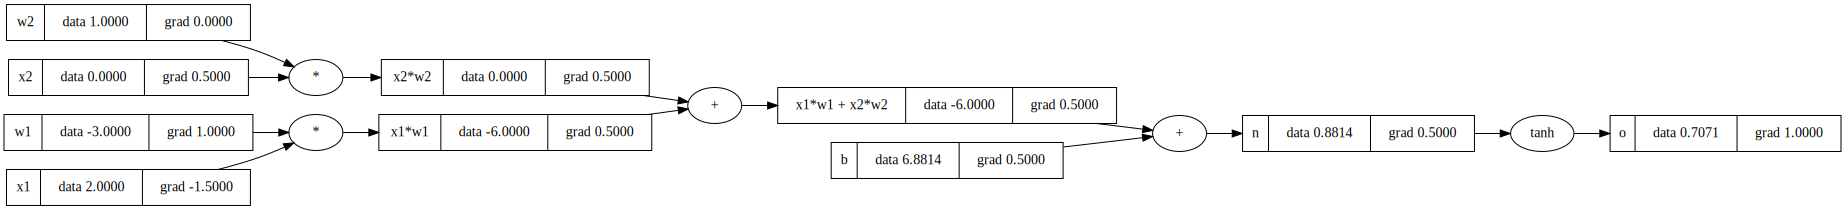

In [105]:
draw_dot(o)

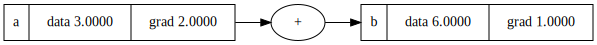

In [106]:
# bug: 'a' refers to the same Value object, first gradient should be 2
# ; uncomment in __add__ and __mul__ to produce

a = Value(3.0, label='a')
b = a + a; b.label= 'b'
b.backward()
draw_dot(b)

In [107]:
# second bug demo ; uncomment in __add__ and __mul__ to produce

a = Value(-2.0, label='a')
b = Value(3.0, label= 'b')
d = a * b; d.label='d'
e = a + b; e.label='e'
f = d * e; f.label='f'

In [108]:
f.backward()

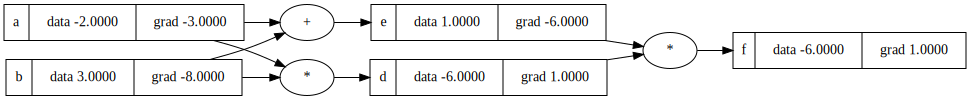

In [109]:
draw_dot(f)